<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Volkskrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and loading data

In [1]:
import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')
import seaborn as sns
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
path_to_json = "gdrive/MyDrive/CS/Thesis/volkskrant-nl"
json_files = ["gdrive/MyDrive/CS/Thesis/volkskrant-nl/"+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files[:5])

['gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-01.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-02.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-03.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-04.json', 'gdrive/MyDrive/CS/Thesis/volkskrant-nl/volkskrant-nl-2002-05.json']


In [4]:
def readFiles(file_names):
  dfs = [] # an empty list to store the data frames
  for f in tqdm(file_names):
    data = pd.read_json(f) # read data frame from json file
    dfs.append(data) # append the data frame to the list

  df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
  return df

In [5]:
df = readFiles(json_files)
df.shape

100%|██████████| 214/214 [06:42<00:00,  1.88s/it]


(862852, 14)

In [6]:
df.tail(2)

,categories,cleaned,cleantext,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,timestamp,title,url
862850,Nieuws &amp; Achtergrond,2019-10-16T20:57:04.925000,De nieuwsredactie van de Volkskrant. Beeld Sim...,"[De Volkskrant, economie, business en financië...",https://images4.persgroep.net/rcs/zZXXTbiZRNbQ...,De nieuwsredactie van de Volkskrant.,Beeld Simon Lenskens,Beeld Simon Lenskens,De Volkskrant zoekt freelance-internetredacteu...,https://images4.persgroep.net/rcs/zZXXTbiZRNbQ...,De Volkskrant zoekt internetredacteuren,2019-10-10 07:50:00,De Volkskrant zoekt internetredacteuren,https://www.volkskrant.nl/nieuws-achtergrond/d...
862851,Economie,2019-10-16T22:25:15.752000,Aviko is het tweede grootste aardappelverwerke...,"[Colombia, economie, business en financiën, ec...",https://images0.persgroep.net/rcs/nxqS6pJvbjRy...,Aviko is het tweede grootste aardappelverwerke...,Beeld Hollandse Hoogte / John van Hamond,Beeld Hollandse Hoogte / John van Hamond,Brussel stapt naar de Wereldhandelsorganisatie...,https://images0.persgroep.net/rcs/nxqS6pJvbjRy...,EU naar Wereldhandelsorganisatie wegens Colomb...,2019-10-15 15:10:00,EU naar Wereldhandelsorganisatie wegens Colomb...,https://www.volkskrant.nl/economie/minister-ka...


# Exploratory Data Analysis

Text(0.5, 1.0, 'Total number of articles')

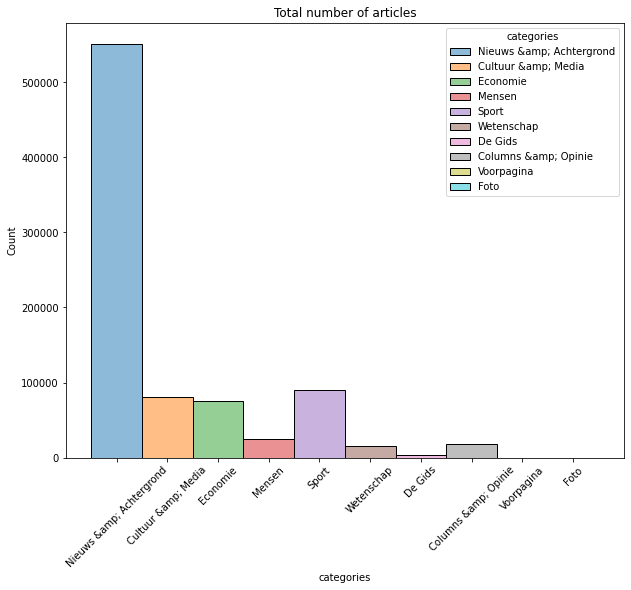

In [7]:
f, axs = plt.subplots(1,figsize=(10, 8))
sns.histplot(data=df, x="categories", hue="categories", ax=axs)
axs.tick_params(axis='x', rotation=45)
axs.set_title("Total number of articles")

Text(0.5, 1.0, 'Number of articles')

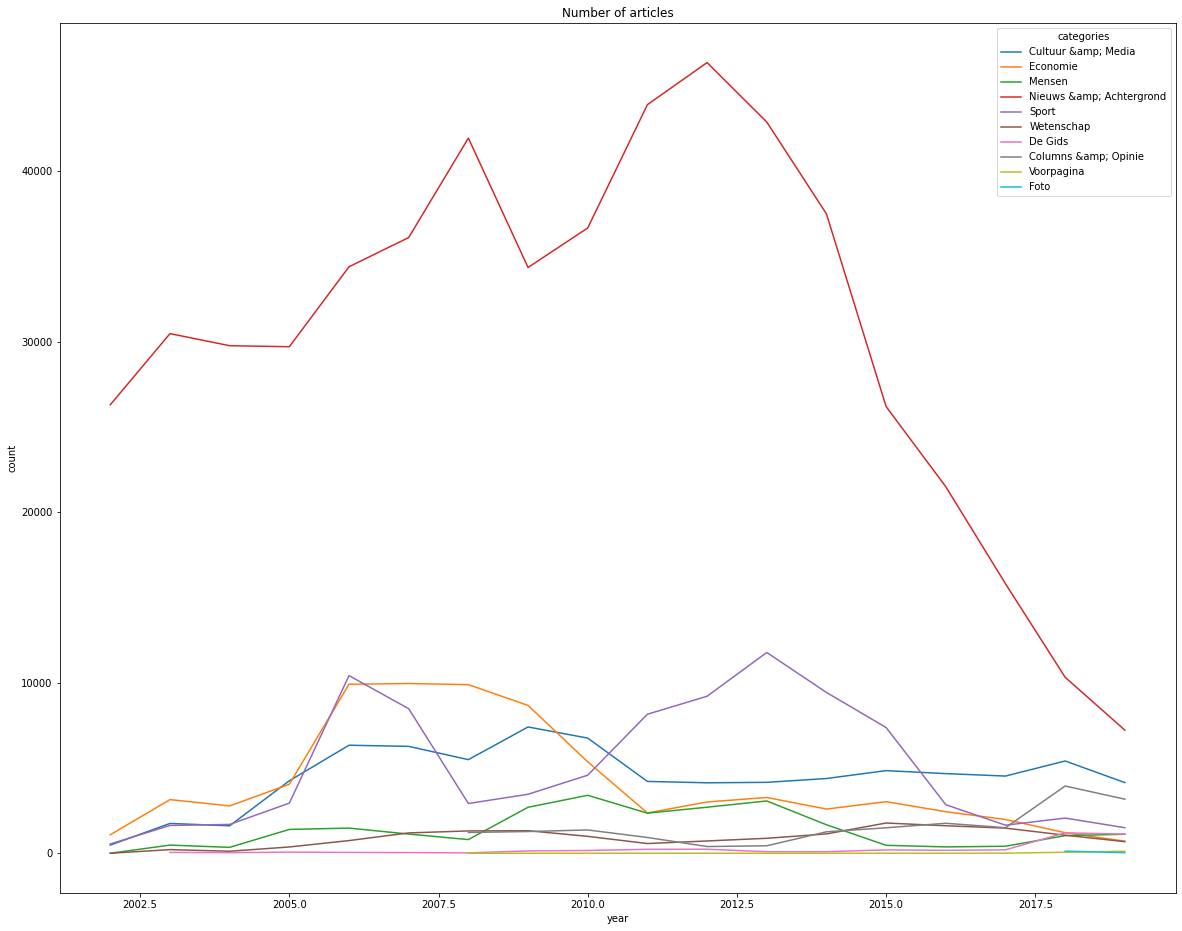

In [8]:
df_year = df.copy(deep=True)
df_year["year"] = df_year.timestamp.dt.year
time_df = pd.DataFrame({'count':df_year.groupby(["year","categories"]).size()}).reset_index()
f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=time_df, x='year',y='count',hue='categories',ci=None, palette=["C0", "C1", "C2", "C3", "C4",
                                                                                 "C5", "C6", "C7", "C8", "C9"])
axs.set_title("Number of articles")

The counts of articles collected per year per category vary quite a bit with for example ~45.000 "News & Background" articles in 2012 and ~10.000 in 2019. These should be normalised when counting party or politician mentions for example. 

Text(0.5, 1.0, 'Total length of articles')

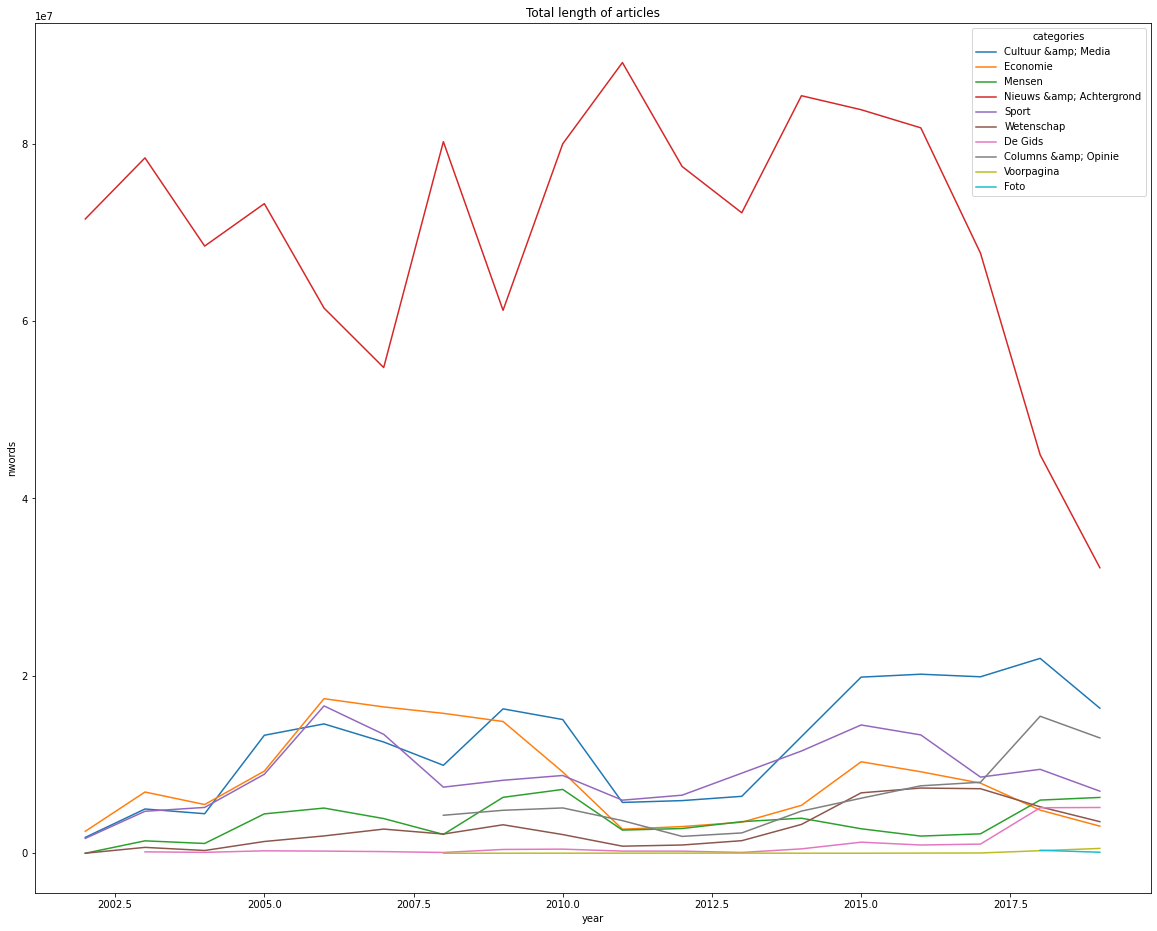

In [9]:
df_nwords = df.copy(deep=True)
df_nwords["year"] = df_nwords.timestamp.dt.year
df_nwords["nwords"] = df_nwords.cleantext.str.len()
df_nwords = pd.DataFrame(df_nwords.groupby(["year","categories"])["nwords"].agg("sum")).reset_index()

f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_nwords, x='year',y='nwords',hue='categories',ci=None, palette=["C0", "C1", "C2", "C3", "C4",
                                                                                 "C5", "C6", "C7", "C8", "C9"])
axs.set_title("Total length of articles")

The total amount of words collected is highest for news and background articles. This graph shows a different balance in data.

# Frequentie politieke partijen

In [10]:
# Lijst partijen tweede kamer per jaar: 
# Bron: https://www.parlement.com/id/vk9scmucgjhj/aantal_deelnemende_partijen_tweede

tk_2002 = ["CDA", "LPF", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "LN"]
tk_2003 = ["CDA", "LPF", "VVD", "PvdA", "GnL", "SP", "D66", "CU", "SGP"]
tk_2006 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD"]
tk_2010 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD"]
tk_2012 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS"]
tk_2017 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS", "DENK", "FVD"]
tk_2021 = ["CDA", "VVD", "PvdA", "GL", "SP", "D66", "CU", "SGP", "PVV", "PvdD", "50PLUS", "DENK",
           "FVD", "BIJ1", "BBB", "JA21", "VOLT"]

# Convert to one unique list
tk = [tk_2002, tk_2003,tk_2006,tk_2010,tk_2012,tk_2017,tk_2021]
tk = [item for sublist in tk for item in sublist]
partijen = list(set(tk))
print(partijen)

['LPF', 'VOLT', 'GL', 'PVV', 'VVD', 'PvdD', 'BBB', 'PvdA', 'BIJ1', 'CU', 'DENK', 'SGP', 'GnL', 'D66', 'SP', '50PLUS', 'CDA', 'JA21', 'LN', 'FVD']


In [11]:
df_partij = df.copy(deep=True)
df_partij["year"] = df_partij.timestamp.dt.year

for p in partijen:
  df_partij[p] = df_partij.cleantext.str.count(p)

df_party_counts = pd.DataFrame()

for p in partijen:
  df_party_counts[p] = df_partij.groupby(["year"])[p].agg("sum")

df_party_counts = df_party_counts.reset_index()
df_mentions = df_party_counts.melt('year')

In [12]:
df_mentions = df_mentions.rename(columns={'year':'Year','variable':'Party','value':'Frequency'})

# Drop rows where frequency is <1000
df_mentions = df_mentions[df_mentions.Frequency > 1000]
print(df_mentions.head())

    Year Party  Frequency
0   2002   LPF       3630
1   2003   LPF       1426
60  2008   PVV       1253
61  2009   PVV       2907
62  2010   PVV       7906


Text(0.5, 1.0, 'Party mentions in Volkskrant')

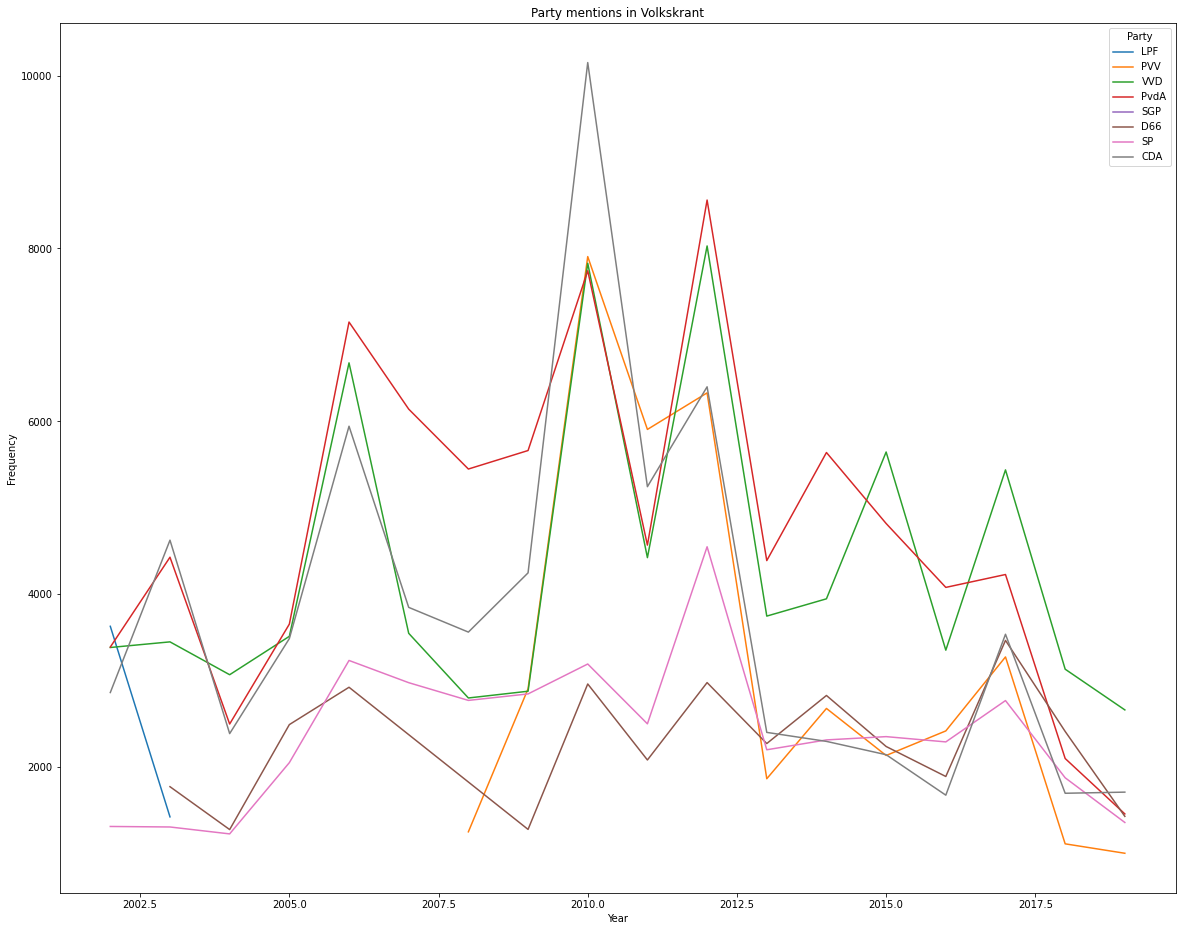

In [13]:
f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_mentions, x='Year',y='Frequency', hue='Party')
axs.set_title("Party mentions in Volkskrant")

# Frequentie politici

In [14]:
politici = ["Kees van der Staaij", "Sigrid Kaag", "Lilian Marijnissen", "Geert Wilders", "Wopke Hoekstra", "Lilianne Ploumen", "Mark Rutte"]

In [15]:
# Computing number of articles per year to normalise counts
df_norm = time_df.groupby("year").sum("count").reset_index()
df_norm = df_norm.rename(columns={"year":"Year", "count":"Articles"})
print(df_norm.head())

   Year  Articles
0  2002     28425
1  2003     37758
2  2004     36359
3  2005     42793
4  2006     63351


In [16]:
# Count occurence of politicians
df_politici = df.copy(deep=True)
df_politici["year"] = df_politici.timestamp.dt.year

for p in politici:
  df_politici[p] = df_politici.cleantext.str.count(p)

df_politici_counts = pd.DataFrame()

for p in politici:
  df_politici_counts[p] = df_politici.groupby(["year"])[p].agg("sum")

df_politici_counts = df_politici_counts.reset_index()
df_pol_mentions = df_politici_counts.melt('year')

df_pol_mentions = df_pol_mentions.rename(columns={'year':'Year','variable':'Politician','value':'Frequency'})

df_pol_mentions.tail()

,Year,Politician,Frequency
121,2015,Mark Rutte,1083
122,2016,Mark Rutte,913
123,2017,Mark Rutte,1231
124,2018,Mark Rutte,794
125,2019,Mark Rutte,591


In [17]:
df_pol_mentions = df_pol_mentions.merge(df_norm, on="Year")
print(df_pol_mentions.head())

   Year           Politician  Frequency  Articles
0  2002  Kees van der Staaij          2     28425
1  2002          Sigrid Kaag          0     28425
2  2002   Lilian Marijnissen          0     28425
3  2002        Geert Wilders          6     28425
4  2002       Wopke Hoekstra          0     28425


   Year           Politician  Frequency  Articles  Normalised Freq
0  2002  Kees van der Staaij          2     28425         0.703606
1  2002          Sigrid Kaag          0     28425         0.000000
2  2002   Lilian Marijnissen          0     28425         0.000000
3  2002        Geert Wilders          6     28425         2.110818
4  2002       Wopke Hoekstra          0     28425         0.000000


Text(0.5, 1.0, 'Politician mentions in Volkskrant (normalised)')

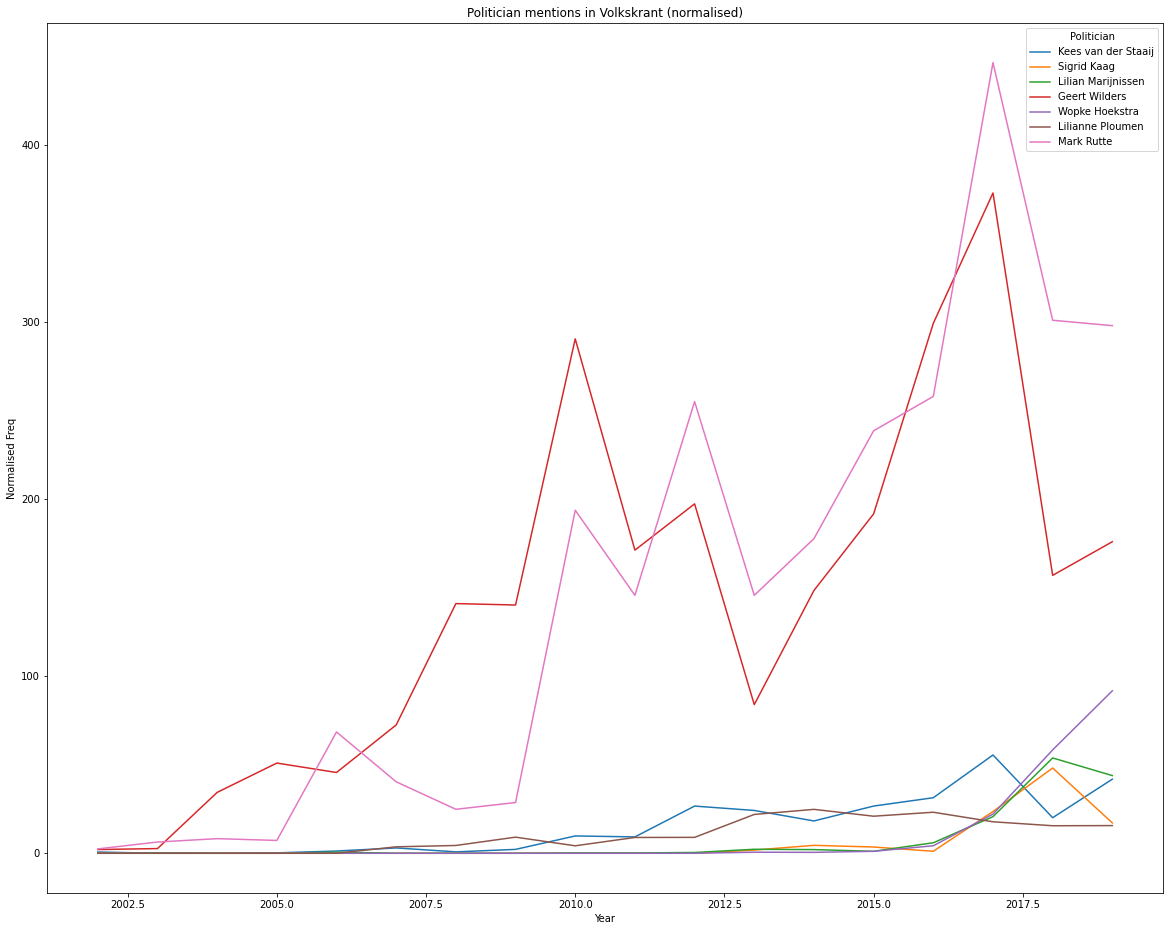

In [18]:
# Drop rows where frequency is <1000
# df_pol_mentions = df_pol_mentions[df_pol_mentions.Frequency > 1000]
# print(df_pol_mentions.head())
df_pol_mentions["Normalised Freq"] = df_pol_mentions["Frequency"]/df_pol_mentions["Articles"]*10000
print(df_pol_mentions.head())

f, axs = plt.subplots(1,figsize=(20, 16))
sns.lineplot(data=df_pol_mentions, x='Year',y='Normalised Freq', hue='Politician')
axs.set_title("Politician mentions in Volkskrant (normalised)")

In [50]:
from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models

In [41]:
volkskrant_corpus = list(df["cleantext"].values)
print(len(volkskrant_corpus))

862852


In [51]:
class VolkskrantCorpus():
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, corpus):
      self.corpus = corpus

    def __iter__(self):
        for line in self.corpus:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [ ]:
sentences = VolkskrantCorpus(volkskrant_corpus)
model = gensim.models.Word2Vec(sentences=sentences)

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

In [ ]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)